# Bicycle Accidents x Geo Data x Strava Exposure Merge

<small>

```bash
# Create virtual environment
python3 -m venv .venv
source .venv/bin/activate

# Install requitements from .toml file
pip install -e .
```

<small>

## Prerequisites for Latex-friendly Figures

This notebook uses **tueplots** with LaTeX rendering for visualizations. 

### Required Setup:

**1. Install TinyTeX (LaTeX distribution)**
```bash
# Option A: Via R (if you have R installed)
Rscript -e "tinytex::install_tinytex()"

# Option B: Direct installer (macOS)
curl -sL "https://yihui.org/tinytex/install-bin-unix.sh" | sh
```

**2. Install Required LaTeX Packages**
```bash
tlmgr update --self
tlmgr install type1cm cm-super underscore dvipng
```

**3. Add TinyTeX to PATH**
```bash
echo 'export PATH="$HOME/Library/TinyTeX/bin/universal-darwin:$PATH"' >> ~/.zshrc
source ~/.zshrc
```

**4. Verify Installation**
```bash
which latex && which dvipng
```

</small>

In [1]:
import sys
from pathlib import Path

# Ensure project root is importable when running from notebooks/
_project_root = Path.cwd().resolve()
if not (_project_root / "src").exists() and (_project_root.parent / "src").exists():
    _project_root = _project_root.parent
sys.path.insert(0, str(_project_root))

import os
os.environ['PATH'] = f"{os.path.expanduser('~/Library/TinyTeX/bin/universal-darwin')}:{os.environ['PATH']}"

import datetime as dt
import gc
import importlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import openpyxl
import branca.colormap as cm
import folium
from folium.features import GeoJsonTooltip
import json
from tueplots import bundles
from tueplots.constants.color import palettes


# Module imports
import src.accidents as accidents
import src.segments as segments
import src.strava_exposure as strava_exposure
import src.panels as panels
import src.nodes as nodes
import src.counting_stations as cs_module

# Reload project modules to get latest changes
for _m in (accidents, segments, strava_exposure, panels, nodes, cs_module):
    importlib.reload(_m)

from src.accidents import (
    ACCIDENT_COLUMNS_EN,
    assign_accidents_to_nearest_segment,
    load_accidents_raw,
    prepare_accidents_bike_berlin,
    plot_accident_quality_overview,
)
from src.segments import load_segment_geometry, plot_segment_quality_overview
from src.strava_exposure import (
    build_exposure_panel_segment_year_month,
    column_stability_summary,
    compute_segment_filter_impact,
    filter_zero_traffic_years,
    get_daily_outlier_days,
    load_strava_berlin_data,
    plot_strava_quality_overview,
)
from src.panels import (
    aggregate_accidents_segment_year_month_rich,
    merge_exposure_and_accidents,
    plot_merged_panel_quality_overview,
)
from src.nodes import (
    assign_accidents_to_nearest_crossing,
    build_node_exposure_panel_from_segments,
    build_nodes_from_segment_endpoints,
    cluster_nodes_snap_grid,
    print_node_exposure_quality_summary,
    select_crossings_by_degree,
)
from src.counting_stations import (
    load_counting_stations,
    match_counting_stations_to_segments,
    build_station_strava_comparison_panel
)

# Configuration constants
DATA_DIR = _project_root / "data"
MERGED_DIR = DATA_DIR / "panel"
CANONICAL_CRS = "EPSG:32633"
MAX_DISTANCE_M = 10
MAX_DISTANCE_M_NEREAST_CROSSING = 20
NODE_SNAP_TOLERANCE_M = 2
CROSSING_MIN_DEGREE = 3


def save_panel(df, filename, crs=None, format='parquet'):
    """Save dataframe to parquet or CSV format in /panel directory.
    """
    MERGED_DIR.mkdir(parents=True, exist_ok=True)
    
    # Adjust filename extension based on format
    if format == 'csv':
        filename = filename.replace('.parquet', '.csv')
    elif format == 'parquet':
        filename = filename.replace('.csv', '.parquet')
    
    out_path = MERGED_DIR / filename
    
    if crs is not None:
        df = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    
    if format == 'csv':
        df.to_csv(out_path, index=False)
    else:  # parquet

        df.to_parquet(out_path, index=False, engine='pyarrow', coerce_timestamps='ms'),
        return out_path

    print(f"Saved: {out_path}")

## Raw Datasets

### 1. Accident Data
- **Source**: [Destatis Unfallatlas](https://unfallatlas.statistikportal.de/)
- **Time Coverage**: 2019-2023 (as we have Strava exposure data for relative years only)
- **Files**: CSV files from `data/accidents/` directory (Unfallorte_201[9-2023]_LinRef.csv)
- **Description**: Personal injury bicycle accidents in Berlin, Germany. The Accident Atlas contains accidents with personal injury only; material-damage-only accidents are excluded.
- **Key Fields**: Accident location coordinates, date, severity, accident type, street and other conditions
- **Limitation**: In accidents data we don't have specific datetime of accidents, only month, weekday and hour

### 2. Strava Exposure Data
- **Source**: [Urban Traffic Volume Dataset – Berlin (Strava), Zenodo](https://zenodo.org/records/15332147)
- **License**: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **File**: `data/strava/berlin_data.parquet` (460.3 MB)
- **Time Coverage**: 2019-2023 (daily bicycle traffic volumes)
- **Description**: Daily bicycle traffic volumes aggregated from publicly shared Strava user data. Strava volumes are rounded aggregates of bike trips, with extreme outliers filtered per segment to focus on typical traffic conditions.
- **Auxiliary Features**: Built environment (speed limits, road types, lane counts), Points of Interest (shops, schools, transit stops), network connectivity metrics (degree, betweenness), temporal indicators (weekday, holidays, month), weather data (sunshine, precipitation, temperature), socioeconomic indicators, proxy motorized traffic metrics
- **Key Fields**: Segment identifiers, temporal aggregation (year/month), trip counts, activity metrics, environmental and infrastructure features

### 3. Road Network Geometry
- **Source**: [Urban Traffic Volume Dataset – Berlin (Strava), Zenodo](https://zenodo.org/records/15332147)
- **License**: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **File**: `data/strava/berlin_graph_geometry.parquet` (1.6 MB)
- **CRS**: EPSG:32633 (UTM Zone 33N)
- **Description**: Geospatial representation of Berlin's road network at street-segment level with geometric attributes
- **Key Fields**: Segment IDs, LineString geometries, segment properties

### Citation
For Strava Berlin dataset:
> Kaiser, S. K., Rodrigues, F., Azevedo Lima, C., & Kaack, L.H. (2025). Spatio-Temporal Graph Neural Network for Urban Spaces: Interpolating Citywide Traffic Volume. [published on arXiv].

In [2]:
accidents_raw = load_accidents_raw(csv_dir=DATA_DIR / "accidents")
segments_geometry_raw = load_segment_geometry(parquet_path = DATA_DIR / "strava" / "berlin_graph_geometry.parquet", canonical_crs=CANONICAL_CRS)
strava_berlin_data_raw = load_strava_berlin_data(parquet_path=DATA_DIR / "strava" / "berlin_data.parquet")

Reading berlin_graph_geometry.parquet locally from /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/strava/berlin_graph_geometry.parquet
Reading berlin_data.parquet locally from /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/strava/berlin_data.parquet


# Data preprocessing & Data Quality Check

## Accidents data

In [3]:
accidents_bike_berlin = prepare_accidents_bike_berlin(accidents_raw, column_map=ACCIDENT_COLUMNS_EN)

print("Raw accidents shape:", accidents_raw.shape)
pct_remaining = (accidents_bike_berlin.shape[0] / accidents_raw.shape[0]) * 100
print(f"Filtered to bicycle accidents in Berlin (bike type + Berlin bounds) -> shape: {accidents_bike_berlin.shape} ({pct_remaining:.1f}% of original)")

# Free big raw dataframe early to keep memory low for Strava aggregatio
del accidents_raw
gc.collect()

Raw accidents shape: (1270730, 28)
Filtered to bicycle accidents in Berlin (bike type + Berlin bounds) -> shape: (23537, 28) (1.9% of original)


952

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/accidents.py:431: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.94, hspace=0.4, wspace=0.3)


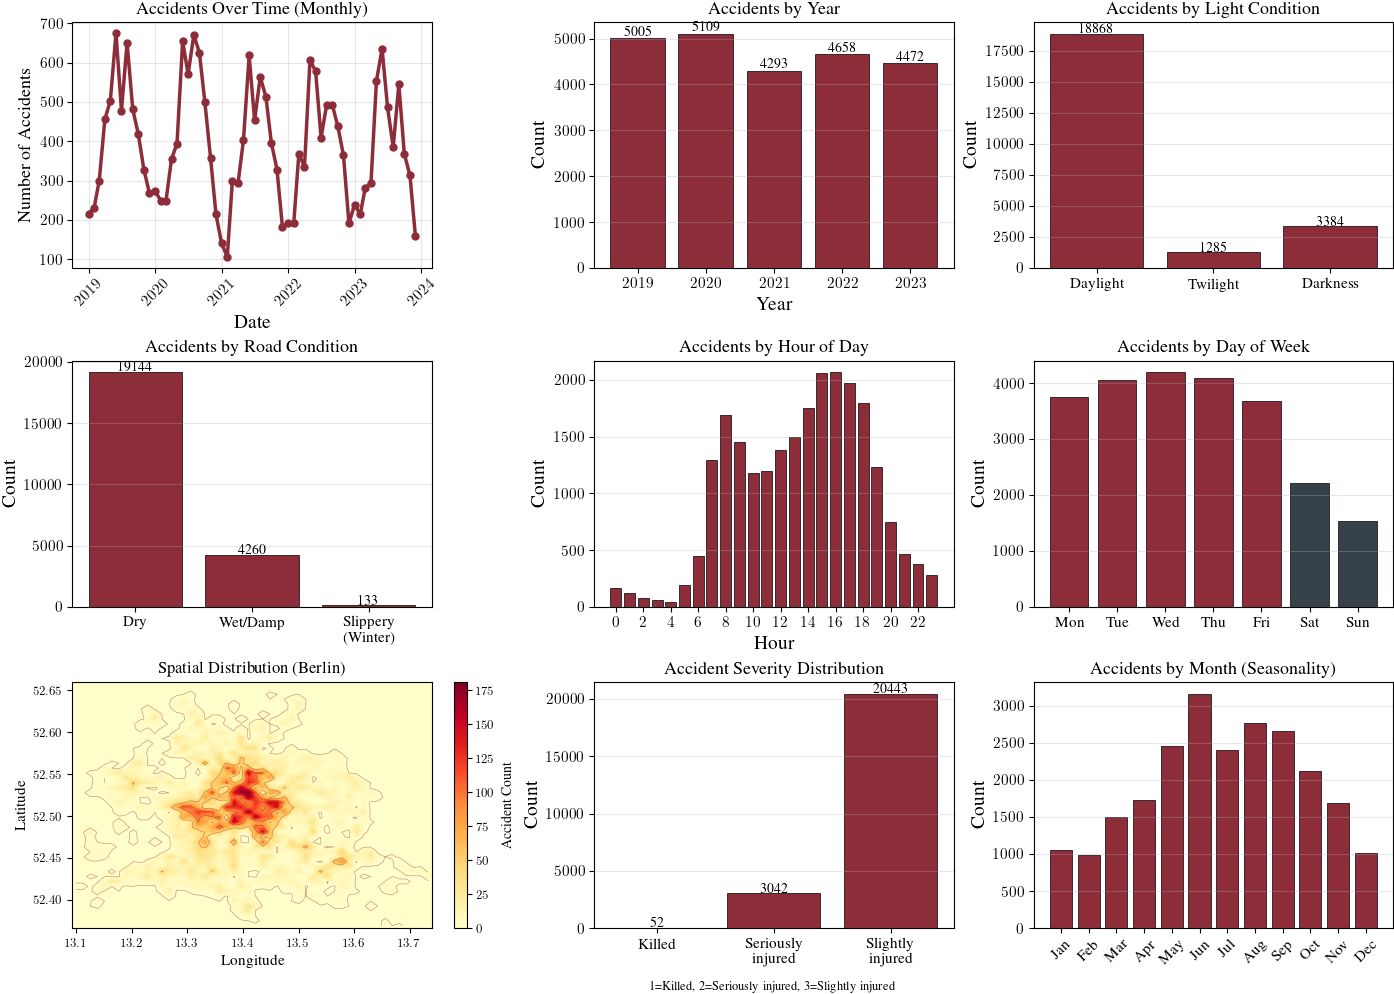


============================SUMMARY STATISTICS============================
Total accidents: 23,537
Date range: 2019 - 2023
Number of columns: 28

[PASS] Duplicate check (accident_id_extended)
  - Total non-null records: 18,532
  - Unique IDs: 18,532
  - Duplicates: 0
  - Missing IDs (NaN): 5,005

[PASS] Temporal validity check (2019-2023)
  - All records within expected range (2019-2023)

Missing values in accident features and geographic columns:
  No missing values in accident features and geographic columns!


In [4]:
plot_accident_quality_overview(
    accidents_bike_berlin, 
    use_tueplots=True,
    save_path=None  # Set to "accident_overview_icml.pdf" to save
)

**Data Quality Summary**

After filtering to Berlin bicycle accidents in our dataset:
- **Final dataset size**: 23,537 records (1.9% of original raw dataset)
- **Temporal coverage**: Consistent across 2019-2023
- **Duplicate records**: ~1% by accident characteristics → to be removed
- **Missing `accident_id_extended`**: 21.2% of records, but only from 2019 (field not collected that year)
- **Other fields**: No quality issues detected

**Conclusion**: Dataset is ready for spatial and temporal analysis.

In [5]:
duplicate_cols = [col for col in [
    'year', 'month', 'weekday', 'hour', 'XGCSWGS84', 'YGCSWGS84',
    'injury_severity', 'accident_kind', 'accident_type',
    'light_condition', 'road_condition_flag',
    'involved_bicycle', 'involved_passenger_car', 'involved_pedestrian',
    'involved_motorcycle', 'involved_goods_vehicle', 'involved_other_vehicle',
] if col in accidents_bike_berlin.columns]

n_before = len(accidents_bike_berlin)
accidents_bike_berlin = accidents_bike_berlin.drop_duplicates(subset=duplicate_cols, keep='first')
n_removed = n_before - len(accidents_bike_berlin)

print(f"Duplicate removal: {n_before:,} → {len(accidents_bike_berlin):,} records (-{100*n_removed/n_before:.2f}%)")

save_panel(accidents_bike_berlin, "berlin_bike_accidents.parquet", format='csv')

Duplicate removal: 23,537 → 23,535 records (-0.01%)
Saved: /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accidents.csv


## Road Network Geometry

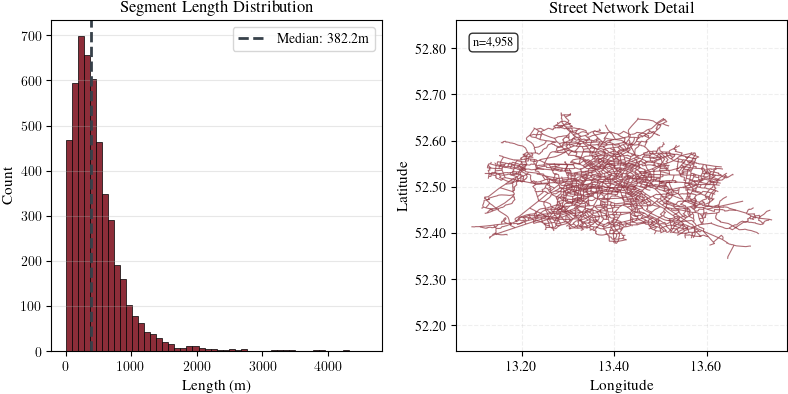


============================SUMMARY STATISTICS============================
Total segments: 4,958
Number of columns: 4

[PASS] Valid Geometry
  Description: All geometries are valid (invalid: 0)

[PASS] No Empty Geometry
  Description: No empty geometries (empty: 0)

[PASS] Coordinate Range (Berlin)
  Description: Coordinates within Berlin bounds (lat: 52.3-52.7, lon: 13.0-13.8)

[PASS] Unique Segment IDs
  Description: All segment IDs are unique (total: 4958, unique: 4958)

[PASS] Reasonable Lengths (1-5000m)
  Description: All lengths in valid range (too short: 0, too long: 0)

No missing values detected!


In [6]:
segment_geo_gdf = segments_geometry_raw.segments_gdf
segment_static = segments_geometry_raw.segment_static

plot_segment_quality_overview(segment_geo_gdf, use_tueplots=True)

**Segment Geometry Quality Assessment**

Road network segment data validation completed:
- **Geometry validity**: All geometries valid and complete
- **Segment lengths**: Within reasonable bounds (1–5000 m)
- **Coordinate coverage**: Verified for Berlin area (52.3–52.7°N, 13.0–13.8°E)
- **Duplicate segment IDs**: None detected
- **Data completeness**: No missing coordinate values

**Conclusion**: Geometry data ready for spatial joins and analysis.

## Strava Exposure Data

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/strava_exposure.py:368: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.4, wspace=0.35)


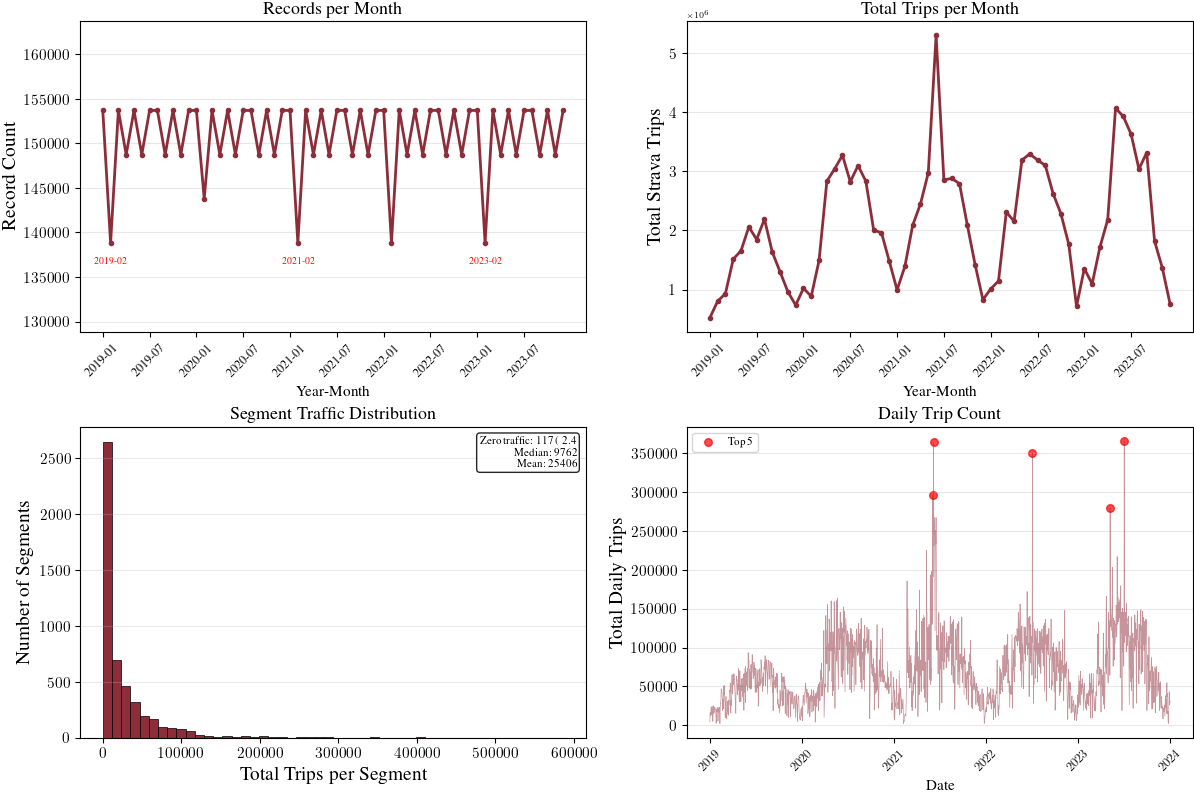


===================== SUMMARY STATISTICS =====================
Total records: 9,053,308
Number of columns: 137

Data Quality Checks:
[PASS] Temporal Coverage (2019-2023)
  Date range: 2019-2023 (expected: 2019-2023)
[PASS] No Duplicate Records (segment+date)
  Unique records by segment+date
[PASS] Non-negative Trip Counts
  All trip counts non-negative
[FAIL] No Segments with Zero Traffic
  Zero traffic found in 117 segments (2.4%)
[PASS] Segment Coverage Consistency
  4,958 unique segments, avg 1826 records/segment
[PASS] Temporal Coverage
  2019-01-01 to 2023-12-31, 0 missing days (0.0% of 1826)
[PASS] Missing Values in Coordinates
  All coordinates present

Unique segments: 4,958
  - Segments with zero trips: 117
  - Segment traffic median: 9762
  - Segment traffic max: 586505

Temporal coverage:
  - Total days in range: 1826
  - Days with data: 1826
  - Missing days (gaps): 0 (0.0%)

Trip count statistics:
  - Mean: 13.9
  - Median: 5.0
  - Min: 0.0
  - Max: 4370.0
  - Total trips

In [7]:
plot_strava_quality_overview(strava_berlin_data_raw, use_tueplots=True)

In [8]:
outlier_days_df = get_daily_outlier_days(strava_berlin_data_raw)
outlier_days_df.head()

Date Day of Week  Trip Count  Type
0  2023-07-02      Sunday      365380  High
1  2021-06-06      Sunday      364540  High
2  2022-07-03      Sunday      349880  High
3  2021-06-03    Thursday      296200  High
4  2023-05-07      Sunday      279560  High

Let's check events on top-5 days with high traffic in Berlin:
1. [On July 2, 2023](https://www.tagesspiegel.de/berlin/radwegestopp-nicht-mit-uns-8000-radfahrer-nehmen-an-demonstration-gegen-berliner-verkehrspolitik-teil-10078069.html), thousands of cyclists protested in Berlin against the Senate's decision to halt the expansion of new bike lanes, marching toward the Red City Hall - 
2. [On June 6, 2021](https://berlin.adfc.de/artikel/adfc-sternfahrt-am-sonntag-6-juni-2021-1#:~:text=%E2%80%9C%20hatte%20der%20ADFC%20Berlin%20zu,Stadtgebiet%20f%C3%BCr%20die%20%C3%BCberf%C3%A4llige%20Verkehrswende.), the main bicycle-related events in Berlin included a large city-wide demonstration.
3. [On July 3, 2022](https://www.morgenpost.de/berlin/article401495850/velocity-rennen-strassensperrungen-wegen-radsport-event.html), Berlin hosted the inaugural VeloCity Berlin bicycle race. 
4. [On June 3, 2021](https://www.who.int/campaigns/world-bicycle-day), which coincided with World Bicycle Day.
5. [On May 7, 2023](https://littlebighotels.com/en/events/veloberlin-2023/), the primary bicycling event in Berlin was the VELOBerlin bike festival.

**Strava Exposure Data Quality Assessment**

Validation results:
- **Temporal coverage**: 2019-01-01 to 2023-12-31 with no gaps (1,826 days complete). Note: February months show fewer records due to fewer calendar days (28/29 vs 30/31) → **[PASS]** expected behavior
- **Segments**: 4,958 unique segments; **117 segments with zero traffic (2.4%) → [FAIL]** require filtering
- **Traffic peaks**: Align with cycling events (July 2023 protest, June 2021 demonstrations, VeloCity race, etc.) → **[PASS]**
- **Data quality**: 7/8 checks passed; no negative values; all required columns present

**Conclusion**: Need to filter zero-traffic segments before aggregation to ensure valid exposure variation for modeling.

### Feature Stability Analysis

Computes which columns are constant per segment (varying == 0) for use in downstream aggregation. The aggregation function `build_exposure_panel_segment_year_month()` applies hardcoded strategy:
- **Sum aggregation**: Trip counts (total, ride, e-bike, commute, leisure, by time/demographics), vehicle counts (motorized proxy)
- **Mean aggregation**: Speed metrics
- **Constant features**: Infrastructure (road type, lanes, speed limits) and connectivity (degree, betweenness)

In [9]:
# Compute which columns are constant per segment (for aggregation strategy)
summary_df = column_stability_summary(strava_berlin_data_raw, group_col="counter_name")
# This identifies constant columns (segments_varying == 0) that will be preserved during aggregation

# Datasets aggregation and merging

### Spatial Join: Accidents to Road Segments

Assigns each bicycle accident to its nearest road network segment using `assign_accidents_to_nearest_segment()`.

**Method:**
- Uses `gpd.sjoin_nearest()` with `max_distance_m=10` meters
- Accidents beyond this threshold remain unassigned
- When multiple segments are equidistant, keeps the first one after sorting by distance
- Ensures each accident is assigned to exactly one segment (duplicates removed by `acc_id`)

In [10]:
# Assign each accident to exactly one nearest segment (within max_distance)
joined_nearest_unique = assign_accidents_to_nearest_segment(
    accidents_bike_berlin,
    segment_geo_gdf,
    canonical_crs=CANONICAL_CRS,
    max_distance_m=MAX_DISTANCE_M,
)

# Spatial join validation
coverage = len(joined_nearest_unique) / len(accidents_bike_berlin)
print(f"SPATIAL JOIN:")
print(f"Total accidents: {len(accidents_bike_berlin):,}")
print(f"Assigned accidents: {len(joined_nearest_unique):,} ({coverage:.1%}) [{'PASS' if coverage >= 0.90 else 'WARN'}]")
print(f"Matched segments: {joined_nearest_unique['counter_name'].nunique():,} / {len(segment_geo_gdf):,},\
({joined_nearest_unique['counter_name'].nunique() / len(segment_geo_gdf):.2%})")

SPATIAL JOIN:
Total accidents: 23,535
Assigned accidents: 15,396 (65.4%) [WARN]
Matched segments: 3,286 / 4,958,(66.28%)


### Strava bicycle traffic volume aggregation (segments–year–month)

Converts daily Strava traffic volumes into a segment × year × month panel for risk analysis.

**Aggregation strategy** (hardcoded in `build_exposure_panel_segment_year_month()`):
- **Sum aggregation**: Trip counts (total, ride, commute, leisure, by time of day), people counts (by demographics), vehicle counts (motorized traffic proxy)
- **Mean aggregation**: Speed metrics (average speed per segment per month)
- **Constant features**: Infrastructure attributes (road type, lanes, speed limits), connectivity metrics (degree, betweenness) — stored once per segment

**Why**: Align with accident data temporal granularity (segment–month level) and enable direct exposure-outcome comparisons.  

In [11]:
strava_berlin_data_agg_rich = build_exposure_panel_segment_year_month(
    strava_berlin_data_raw,
    segment_static=segment_static,
    summary_df=summary_df,
)

Before merging exposure and accident panels, we need to understand the effect of 0 traffic volume for segments. 


In [12]:
filter_impact = compute_segment_filter_impact(strava_berlin_data_agg_rich)
display(filter_impact.round(1))

Filter Criterion  Segments Remaining  \
0    Remove segments with 0 traffic (all time)                4841   
1   Remove segments with 0 traffic in any year                4335   
2  Remove segments with 0 traffic in any month                2698   

   Segments Lost  Loss %  
0            117     2.4  
1            623    12.6  
2           2260    45.6

**Why filter zero-traffic years?**

Including segments with any zero-traffic year confounds true exposure variation with data collection gaps. We cannot distinguish whether zero traffic reflects:
- Actual segment inactivity (unmaintained street)
- Monitoring discontinuity (sensor malfunction)
- Deployment timing (segment added mid-study)

So, we keep only segments with positive traffic in all 5 years (2019–2023). Such removal enable us to keep 87,4% of segments.

In [13]:
# Apply filtering: remove segments with zero traffic in any year
strava_berlin_data_agg_reach_clean = filter_zero_traffic_years(strava_berlin_data_agg_rich)

# Loss metrics
baseline = strava_berlin_data_agg_rich['counter_name'].nunique()
filtered = strava_berlin_data_agg_reach_clean['counter_name'].nunique()
pct_loss = (1 - filtered / baseline) * 100

print(f"Segments: {baseline:,} → {filtered:,} (-{pct_loss:.1f}%)")
print(f"Records: {strava_berlin_data_agg_rich.shape[0]:,} → {strava_berlin_data_agg_reach_clean.shape[0]:,}")

Removed 623 segments with zero traffic in any year
Segments remaining: 4,335 (from 4,958)
Segments: 4,958 → 4,335 (-12.6%)
Records: 297,480 → 260,100


### Accidents aggregation (segment–year–month)

Aggregates Unfallatlas accidents assigned to segments into a segment × year × month accident panel.

In [14]:
min_year = int(strava_berlin_data_agg_rich["year"].min())
max_year = int(strava_berlin_data_agg_rich["year"].max())

# accidents_agg_ym_rich
accidents_agg_rich = aggregate_accidents_segment_year_month_rich(
    joined_nearest_unique,
    column_map=ACCIDENT_COLUMNS_EN,
    exposure_year_min=min_year,
    exposure_year_max=max_year,
)

print("Rich accident aggregate (segment–year–month) shape:", accidents_agg_rich.shape)

Rich accident aggregate (segment–year–month) shape: (14084, 64)


### Merge Strategy: LEFT JOIN

Keep all cleaned exposure records and match accidents where they exist. This ensures complete coverage of valid traffic data while allowing zero-accident months (informative for risk modeling).

In [15]:
merge_keys = ["counter_name", "year", "month"]

# Left join: keep all exposure records, attach accidents where they exist
merged_accidents_strava = merge_exposure_and_accidents(
    strava_berlin_data_agg_reach_clean,
    accidents_agg_rich,
    merge_keys=merge_keys,
    trip_col="sum_strava_total_trip_count",
    how='left'
)

# Validation
print(f"Columns in joined datasets: {strava_berlin_data_agg_reach_clean.shape[1]:,} + {accidents_agg_rich.shape[1]:,} - {len(merge_keys):,} (keys) = {strava_berlin_data_agg_reach_clean.shape[1] + accidents_agg_rich.shape[1] - len(merge_keys):,} expected")
print(f"Merged panel: {merged_accidents_strava.shape[0]:,} records, {merged_accidents_strava.shape[1]:,} columns (1 column for flag exposure_row_missing)")
print(f"  Segments: {merged_accidents_strava['counter_name'].nunique():,}")
print(f"  With accidents: {merged_accidents_strava['total_accidents'].notna().sum():,} ({100*merged_accidents_strava['total_accidents'].notna().sum()/len(merged_accidents_strava):.1f}%)")
print(f"  Missing trip data: {merged_accidents_strava['sum_strava_total_trip_count'].isna().sum():,} [should be 0]")

Columns in joined datasets: 132 + 64 - 3 (keys) = 193 expected
Merged panel: 260,100 records, 194 columns (1 column for flag exposure_row_missing)
  Segments: 4,335
  With accidents: 260,100 (100.0%)
  Missing trip data: 0 [should be 0]


### Merged Panel: Quality Checks


/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/panels.py:358: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.3, wspace=0.3)


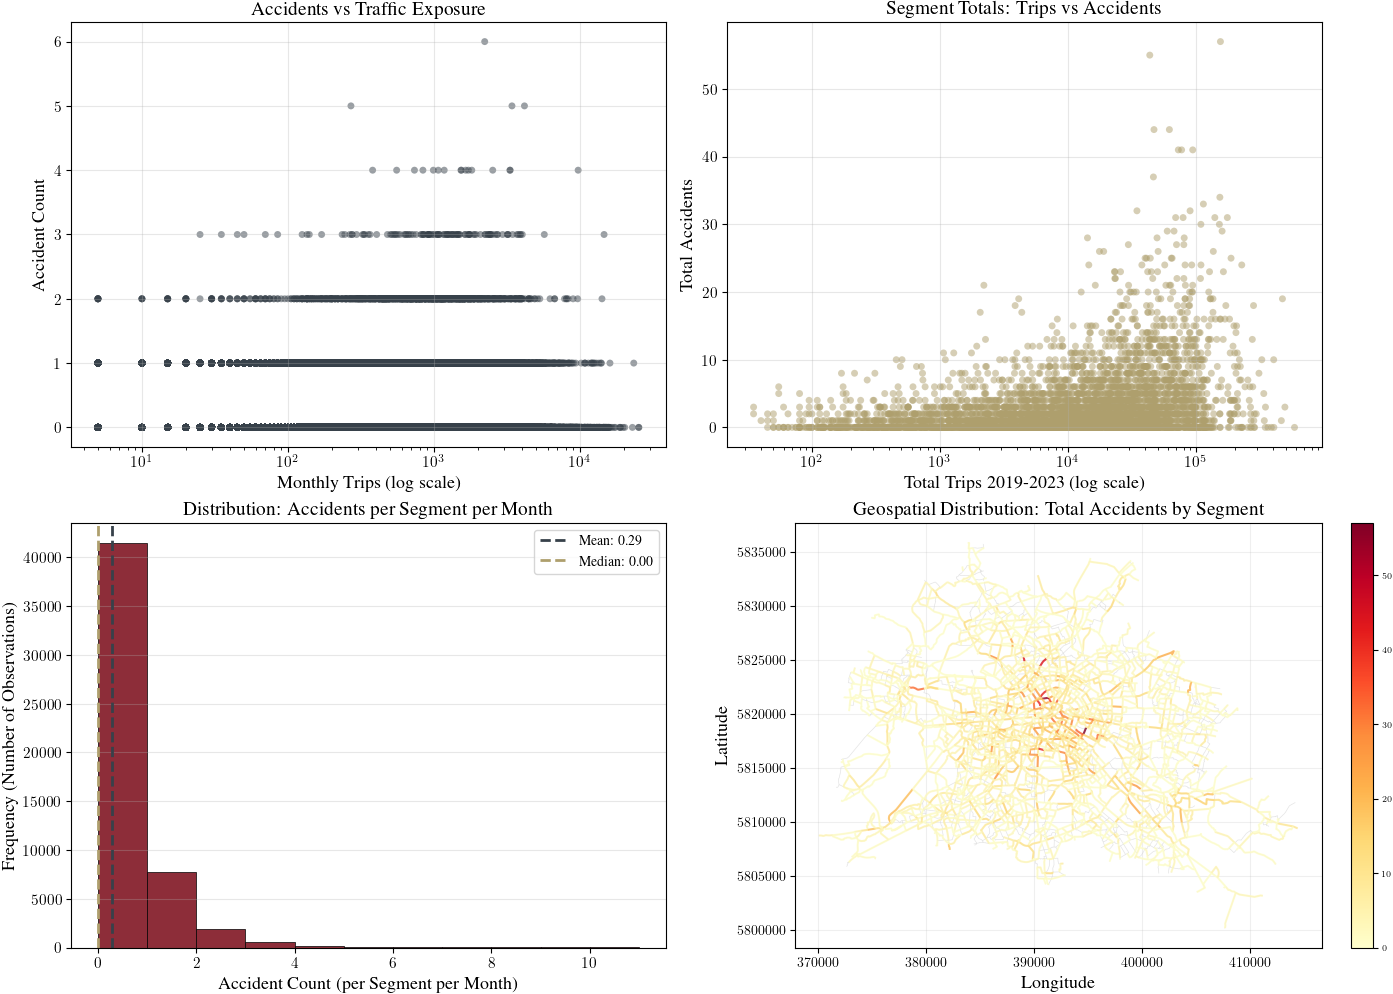

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/panels.py:418: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal_check = merged_panel.groupby('counter_name').apply(



============================SUMMARY STATISTICS============================

[PASS] temporal_consistency
   4335/4335 segments have complete temporal data
   Value: 100.0%

[FAIL] no_negative_values
   Found negative values in: mean_weather_temp_min, mean_socioeconomic_net_migration_per_100
   Value: Multiple

[WARN] plausibility_accidents_vs_trips
   347 rows (0.13%) have more accidents than trips
   Value: 0.13%


In [16]:
fig, axes = plot_merged_panel_quality_overview(
    merged_accidents_strava,
    segment_geometry=segment_geo_gdf,  # Pass segment geometry for map visualization
    trip_col="sum_strava_total_trip_count",
    accident_col="total_accidents",
    figsize=(14, 10),
    use_tueplots=True,
)
plt.show()


In [17]:
# Filter implausible rows where accidents > trips
implausible_mask = (
    merged_accidents_strava['total_accidents'].notna() & 
    (merged_accidents_strava['total_accidents'] > merged_accidents_strava['sum_strava_total_trip_count'])
)
n_before_filter = len(merged_accidents_strava)
merged_accidents_strava = merged_accidents_strava[~implausible_mask].copy()
print(f"Filtered {n_before_filter - len(merged_accidents_strava):,} implausible rows (accidents > trips)")
print(f"Final panel: {len(merged_accidents_strava):,} records")

Filtered 347 implausible rows (accidents > trips)
Final panel: 259,753 records


## Build Nodes (Junctions) from Segment Endpoints

Converts road network segments into junction nodes using a two-stage process:

**Stage 1: Extract Raw Endpoints**
- Each road segment has two endpoints (start/end coordinates)
- Extract all unique endpoints as candidate junction points

**Stage 2: Cluster Nearby Endpoints (Snap Grid)**
- Group endpoints within `NODE_SNAP_TOLERANCE_M = 2` meters of each other
- Merge clustered endpoints into single representative nodes
- Eliminates duplicate junctions caused by coordinate precision or segment discretization

**Output:** Clean junction network properly mapped to the original segment topology

In [18]:
# Build raw nodes from segment endpoints
nodes_raw = build_nodes_from_segment_endpoints(
    segment_geo_gdf,
    counter_col="counter_name",
)

print(f"Raw nodes (all endpoints): {len(nodes_raw):,}")

# Cluster nearby endpoints into unified nodes (snap grid tolerance = 2m)
clustering = cluster_nodes_snap_grid(
    nodes_raw,
    tol_m=NODE_SNAP_TOLERANCE_M,
    counter_col="counter_name",
)

nodes_raw = clustering.nodes_raw
node_points = clustering.node_points
segment_node_map = clustering.segment_node_map

print(f"Clustered nodes (after snapping): {len(node_points):,}")
print(f"Reduction: {len(nodes_raw):,} → {len(node_points):,} ({(1 - len(node_points)/len(nodes_raw))*100:.1f}% merged)")

Raw nodes (all endpoints): 9,916
Clustered nodes (after snapping): 3,155
Reduction: 9,916 → 3,155 (68.2% merged)


### Define Crossings (Intersections)

Select junction nodes that are actual intersections (degree ≥ 3):
- **Degree 1-2**: Endpoints or inline nodes (not intersections)
- **Degree ≥ 3**: True intersections where multiple segments meet

These crossing nodes become the focus for accident analysis.

In [19]:
# Select crossing nodes (degree >= 3)
crossing_ids = select_crossings_by_degree(
    nodes_raw,
    min_degree=CROSSING_MIN_DEGREE,
    counter_col="counter_name",
)

# Filter to only crossing nodes
crossings_gdf = node_points[node_points["node_id"].isin(crossing_ids)].copy()

print(f"Total nodes: {len(node_points):,}")
print(f"Crossing nodes (degree >= {CROSSING_MIN_DEGREE}): {len(crossings_gdf):,}")
print(f"Crossings represent {(len(crossings_gdf) / len(node_points) * 100):.1f}% of all nodes")

Total nodes: 3,155
Crossing nodes (degree >= 3): 2,924
Crossings represent 92.7% of all nodes


### Assign Accidents to Nearest Crossing

Spatial join between accidents and crossing nodes:
- Match each accident to its nearest crossing within `MAX_DISTANCE_M_NEREAST_CROSSING = 20` meters
- Preserve all accident factors (injury severity, type, time of day, etc.) for aggregation
- Build crossing-level accident panel (accidents × crossings × year × month)

In [20]:
# Select columns to preserve for accident factor analysis
factor_cols = ["acc_id", "year", "month", "geometry"]

# Add categorical factors if they exist
factor_cols_optional = [
    "light_condition", "road_condition", "accident_type", "accident_kind", "injury_severity"
]
for col in factor_cols_optional:
    if col in joined_nearest_unique.columns:
        factor_cols.append(col)

study_area_accidents = joined_nearest_unique[factor_cols].copy()

# Assign each accident to nearest crossing (within 20m)
acc_node, acc_node_ym = assign_accidents_to_nearest_crossing(
    study_area_accidents,
    crossings_gdf,
    max_distance_m=MAX_DISTANCE_M_NEREAST_CROSSING,
)

Now we have to subtract the accidents that were assigned to junctions from the segment!

In [21]:
# 1) Accidents that were reassigned to crossings
assigned_acc_ids = (
    acc_node.loc[acc_node["has_crossing"], "acc_id"]
    .dropna()
    .astype(int)
    .unique()
)

# 2) Remove them from the segment-level accident assignments
joined_nearest_no_crossings = joined_nearest_unique.loc[
    ~joined_nearest_unique["acc_id"].isin(assigned_acc_ids)
].copy()

print("Segment accidents before:", len(joined_nearest_unique))
print("Assigned to crossings:", len(assigned_acc_ids))
print("Segment accidents after:", len(joined_nearest_no_crossings))

# 3) Rebuild segment accident aggregates + merged panel
accidents_agg_rich = aggregate_accidents_segment_year_month_rich(
    joined_nearest_no_crossings,
    column_map=ACCIDENT_COLUMNS_EN,
    exposure_year_min=min_year,
    exposure_year_max=max_year,
)

merged_accidents_strava = merge_exposure_and_accidents(
    strava_berlin_data_agg_reach_clean,
    accidents_agg_rich,
    merge_keys=["counter_name", "year", "month"],
    trip_col="sum_strava_total_trip_count",
    how="left",
)

segments_df = merged_accidents_strava.copy()


Segment accidents before: 15396
Assigned to crossings: 4844
Segment accidents after: 10552


In [22]:
# Report assignment results
total_accidents = len(acc_node)
assigned_accidents = int(acc_node["has_crossing"].sum())
unassigned_accidents = total_accidents - assigned_accidents
assignment_rate = (assigned_accidents / total_accidents * 100) if total_accidents > 0 else 0

print(f"\nACCIDENT-TO-CROSSING ASSIGNMENT:")
print(f"Total accidents (in study area): {total_accidents:,}")
print(f"Assigned to crossings: {assigned_accidents:,} ({assignment_rate:.1f}%)")
print(f"\nAccident groups (crossing × year × month): {len(acc_node_ym):,} records")

# Save results
save_panel(acc_node, "acc_node.parquet", format='parquet')


ACCIDENT-TO-CROSSING ASSIGNMENT:
Total accidents (in study area): 15,396
Assigned to crossings: 4,844 (31.5%)

Accident groups (crossing × year × month): 4,597 records


PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/acc_node.parquet')

### Build Node-Level Exposure from Segment Flows

Converts segment × year × month exposure data into crossing (node) × year × month format by aggregating segment traffic.

**Important:** This aggregation is performed **only for crossing nodes** (junctions with degree ≥ 3), not for all nodes.

**Method:** 
- For each crossing node, find all segments connected to that node (via `segment_node_map`)
- Sum trip volumes across all connected segments for each crossing × year × month combination
- Eliminates duplicate segment-node pairs (when start/end collapse to same node)
- **Apply 0.5 correction factor** to account for double-counting: each segment contributes traffic to 2 nodes (start/end), so we multiply the summed exposure by 0.5 to avoid inflating node-level exposure

**Output:** Node-level exposure (corrected trips/month at each crossing), aggregated from all connected segments with double-counting adjustment applied.

In [23]:
# Build node-level exposure panel (crossing × year × month)
crossing_exposure_ym = build_node_exposure_panel_from_segments(
    strava_berlin_data_agg_reach_clean,
    segment_node_map,
    crossing_ids,
    trip_col="sum_strava_total_trip_count",
)

# Quality checks on aggregated node exposure
print_node_exposure_quality_summary(
    crossing_exposure_ym,
    crossings_gdf,
    trip_col="monthly_strava_trips",
)


====================NODE EXPOSURE QUALITY SUMMARY====================

[PASS] dataset_structure
   171,720 records (crossing × year × month combinations)
   Value: 2,862 unique crossings

[PASS] crossing_coverage
   2,862 / 2,924 crossings present in panel (62 crossings absent)
   Value: 97.9%

[PASS] temporal_coverage
   Years: 2019–2023, 60 / 60 expected year-month combinations
   Value: 60 months

[INFO] trip_volume_per_month
   Trips/month per crossing: Mean=723, Median=345, Std=1,118
   Value: Range: 0–26,628

[PASS] no_missing_values_in_records
   0 records with NaN trip values (among 171,720 existing records)
   Value: 0.00%

[INFO] zero_trip_records_per_month
   6,174 month-records with zero trips (out of 171,720 total records)
   Value: 3.60%

[PASS] zero_trip_crossings_all_time
   0 crossings with zero total trips across all years (2019-2023)
   Value: 0.00%


**Node Exposure Panel: Final Data Summary**

**Panel structure:** 171,720 records for 2,862 crossings (2019–2023, 60 months) | **Coverage:** 97.9% (62 crossings missing)

**Missing crossings explanation:** All segments connected to these 62 crossings were filtered during preprocessing (zero-traffic years), so they have no exposure data.

**Data quality:** 
- 3.6% zero-trip month-records (seasonal/temporary closures)

In [24]:
# Exporting the Segments
segments_df = merged_accidents_strava.copy()

# Save
save_panel(
    segments_df,
    "berlin_bike_accident_strava_risk_core_panel.parquet",
    crs=segment_geo_gdf.crs,
    format="parquet",
)


PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accident_strava_risk_core_panel.parquet')

In [25]:
# Exporting the Junctions

# Start from exposure (keeps all node×year×month combos)
junction_df = crossing_exposure_ym.copy()

# Attach accident counts at nodes
acc_cols = [c for c in acc_node_ym.columns if c in ["node_id", "year", "month", "total_accidents"]]
junction_df = junction_df.merge(acc_node_ym[acc_cols], on=["node_id", "year", "month"], how="left")

# Fill missing accident counts
if "total_accidents" in junction_df.columns:
    junction_df["total_accidents"] = junction_df["total_accidents"].fillna(0).astype(int)

# Attach geometry
junction_df = junction_df.merge(
    crossings_gdf[["node_id", "geometry"]],
    on="node_id",
    how="left",
)

# Save
save_panel(
    junction_df,
    "berlin_bike_accident_node_panel.parquet",
    crs=crossings_gdf.crs,
    format="parquet",
)

PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accident_node_panel.parquet')

# Validation of Strava trip counts as a proxy for bike frequency

For our project, we want to estimate the risk of having a cycling accident on certain streets in Berlin. To do this, we need not only the number of accidents on each street, but also some measure of how many bikes use them. There is no data providing exact bike counts for every Berlin street. The city only provides hourly bike counts at certain locations via 20 official bike counting stations (https://viz.berlin.de/en/traffic-in-berlin/bike-traffic/). 


This data is too imprecise to enable proper normalisation of bike frequency, so an alternative is required. We already looked at the data of Kaiser et al. (2025) that contains bike counts from the sports tracking app Strava. There we have the number of trips taken by users of the app on streets within Berlin's official bike lane network (https://www.berlin.de/sen/uvk/mobilitaet-und-verkehr/verkehrsplanung/radverkehr/radverkehrsnetz/karte/). 

Now we want to answer the question, whether the Strava data from Kaiser et al., 2025 is a good proxy for the ground truth data at the official bike counting stations.

### Loading data from the official bike counting stations

In [26]:
# Load official bike counting station data
path = DATA_DIR / "counting_stations" / "gesamtdatei-stundenwerte.xlsx"
counting_stations_location, counting_stations = load_counting_stations(path)

Reading Jahresdatei 2019...
Reading Jahresdatei 2020...
Reading Jahresdatei 2021...
Reading Jahresdatei 2022...
Reading Jahresdatei 2023...


In [27]:
counting_stations.head(3)

datetime 02-MI-JAN-N 01.04.2015 02-MI-JAN-S 01.04.2015  \
0  2019-01-01 00:00:00                     11                     13   
1  2019-01-01 01:00:00                     16                      9   
2  2019-01-01 02:00:00                     19                     18   

  03-MI-SAN-O 01.06.2015 03-MI-SAN-W 01.06.2015 05-FK-OBB-O 01.06.2015  \
0                      0                      8                     12   
1                      0                      7                     33   
2                      0                     13                     26   

  05-FK-OBB-W 01.06.2015 06-FK-FRA-O 01.06.2016 06-FK-FRA-W 01.06.2016  \
0                      8                      7                     17   
1                     31                      7                      1   
2                     38                      9                      3   

  10-PA-BER-N 01.05.2016  ...  year 14-CW-JU-O 27.07.2021  \
0                      5  ...  2019                   NaN   
1                     19  ...  2019                   NaN   
2                     22  ...  2019                   NaN   

  14-CW-JU-W 27.07.2021 02-MI-AL-W 16.12.2021 02-PA-SE-N\n06.10.2022  \
0                   NaN                   NaN                    NaN   
1                   NaN                   NaN                    NaN   
2                   NaN                   NaN                    NaN   

  01-MI-AL-W 16.12.2021 03-SP-NO-O 22.11.2023 03-SP-NO-W 22.11.2023  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   

  04-MI-NO\n16.10.2023 11-PA-SE-N\n06.10.2022  
0                  NaN                    NaN  
1                  NaN                    NaN  
2                  NaN                    NaN  

[3 rows x 37 columns]

Rows are every hour of each day from January 1st 2019 to December 31st 2023. Each column are the hourly counts for a counting station.

### Matching official counting stations to street segments

In [28]:
# Match counting stations to segment network
matched, gdf_strava = match_counting_stations_to_segments(segment_geo_gdf, counting_stations_location)

# 4. DIAGNOSTICS
print("\nDistance diagnostics:")
print(matched["distance_m"].describe())
print("Total stations:", len(matched))
print("Stations with valid match:", matched["counter_name"].notna().sum())
print("Stations without match:", matched["counter_name"].isna().sum())

print("\n\nGood matches (< 30 m):", (matched["distance_m"] < 30).sum())
print("OK matches (30-80 m):", ((matched["distance_m"] >= 30) & (matched["distance_m"] < 80)).sum())
print("Potentially bad matches (> 80 m):", (matched["distance_m"] >= 80).sum())

print("\nUnique matched Strava segments:", matched["counter_name"].nunique())

dups = matched.groupby("counter_name")["station_id"].count().sort_values(ascending=False)
dups[dups > 1]


Distance diagnostics:
count     35.000000
mean      32.954413
std       88.171327
min        0.071621
25%       12.020629
50%       13.332459
75%       25.608075
max      533.793070
Name: distance_m, dtype: float64
Total stations: 35
Stations with valid match: 35
Stations without match: 0


Good matches (< 30 m): 28
OK matches (30-80 m): 6
Potentially bad matches (> 80 m): 1

Unique matched Strava segments: 25


counter_name
streetsegment_2258    3
streetsegment_2228    2
streetsegment_163     2
streetsegment_478     2
streetsegment_4706    2
streetsegment_374     2
streetsegment_492     2
streetsegment_3343    2
streetsegment_3287    2
Name: station_id, dtype: int64

Matching worked and it seems like all stations lie next to one of our segments. But one station has over an 80m! distance to the nearest segment. So let's look whether we have to exclude some counting stations.

In [29]:
# Prep data for folium 
matched_seg_idx = matched["index_right"].dropna().astype(int).unique()
segments4326 = gdf_strava.to_crs(4326)[["geometry", "counter_name"]]

segments_matched = segments4326.loc[matched_seg_idx]
segments_unmatched = segments4326.drop(index=matched_seg_idx, errors="ignore")
stations4326 = matched.to_crs(4326)[["station_id", "counter_name", "distance_m", "geometry"]].copy()

# Colormap for distance gradient (meters)
d = stations4326["distance_m"].to_numpy()
d_finite = d[np.isfinite(d)]
dmin = float(np.nanmin(d_finite)) if d_finite.size else 0.0
dmax = float(np.nanmax(d_finite)) if d_finite.size else 1.0

colormap = cm.linear.YlOrRd_09.scale(dmin, dmax)
colormap.caption = "Station → nearest segment distance (m)"

# Build map
m = folium.Map(location=[52.52, 13.405], zoom_start=12, tiles="CartoDB positron")

folium.GeoJson(
    json.loads(segments_unmatched.to_json()),
    name="Segments (unmatched)",
    style_function=lambda _: {"color": "#666666", "weight": 2, "opacity": 0.6},
    tooltip=GeoJsonTooltip(fields=["counter_name"]),
).add_to(m)

folium.GeoJson(
    json.loads(segments_matched.to_json()),
    name="Segments (matched)",
    style_function=lambda _: {"color": "#ff2d2d", "weight": 4, "opacity": 1.0},
    tooltip=GeoJsonTooltip(fields=["counter_name"]),
).add_to(m)

for _, row in stations4326.iterrows():
    dist = row["distance_m"]
    color = "#999999" if not np.isfinite(dist) else colormap(float(dist))
    tip = (
        f"station_id: {row['station_id']}<br>"
        f"counter_name: {row['counter_name']}<br>"
        f"distance_m: {dist:.1f}"
        if np.isfinite(dist)
        else f"station_id: {row['station_id']}<br>no match"
    )
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        weight=2,
        tooltip=tip,
    ).add_to(m)

colormap.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)
m


Looks good except for the station 23-TK-KAI that does not lie on our segments, so we remove it! Also something to notice it, that we have official count stations that lie on both sides of a segment and count the traffic in either direction. The strava data is undirected so we should combine those counts for our validation.

In [30]:
matched = matched[matched["station_id"] != "23-TK-KAI"].copy()

### Comparing traffic counts

Next we'll build a dataframe that contains the daily bicycle and Strava trip counts for the street segments for which we have both. 

In [31]:
# Build combined panel of official counting station and Strava data
long_daily = build_station_strava_comparison_panel(counting_stations, matched, strava_berlin_data_raw)

Now we plot the Strava and official count for all the segments.

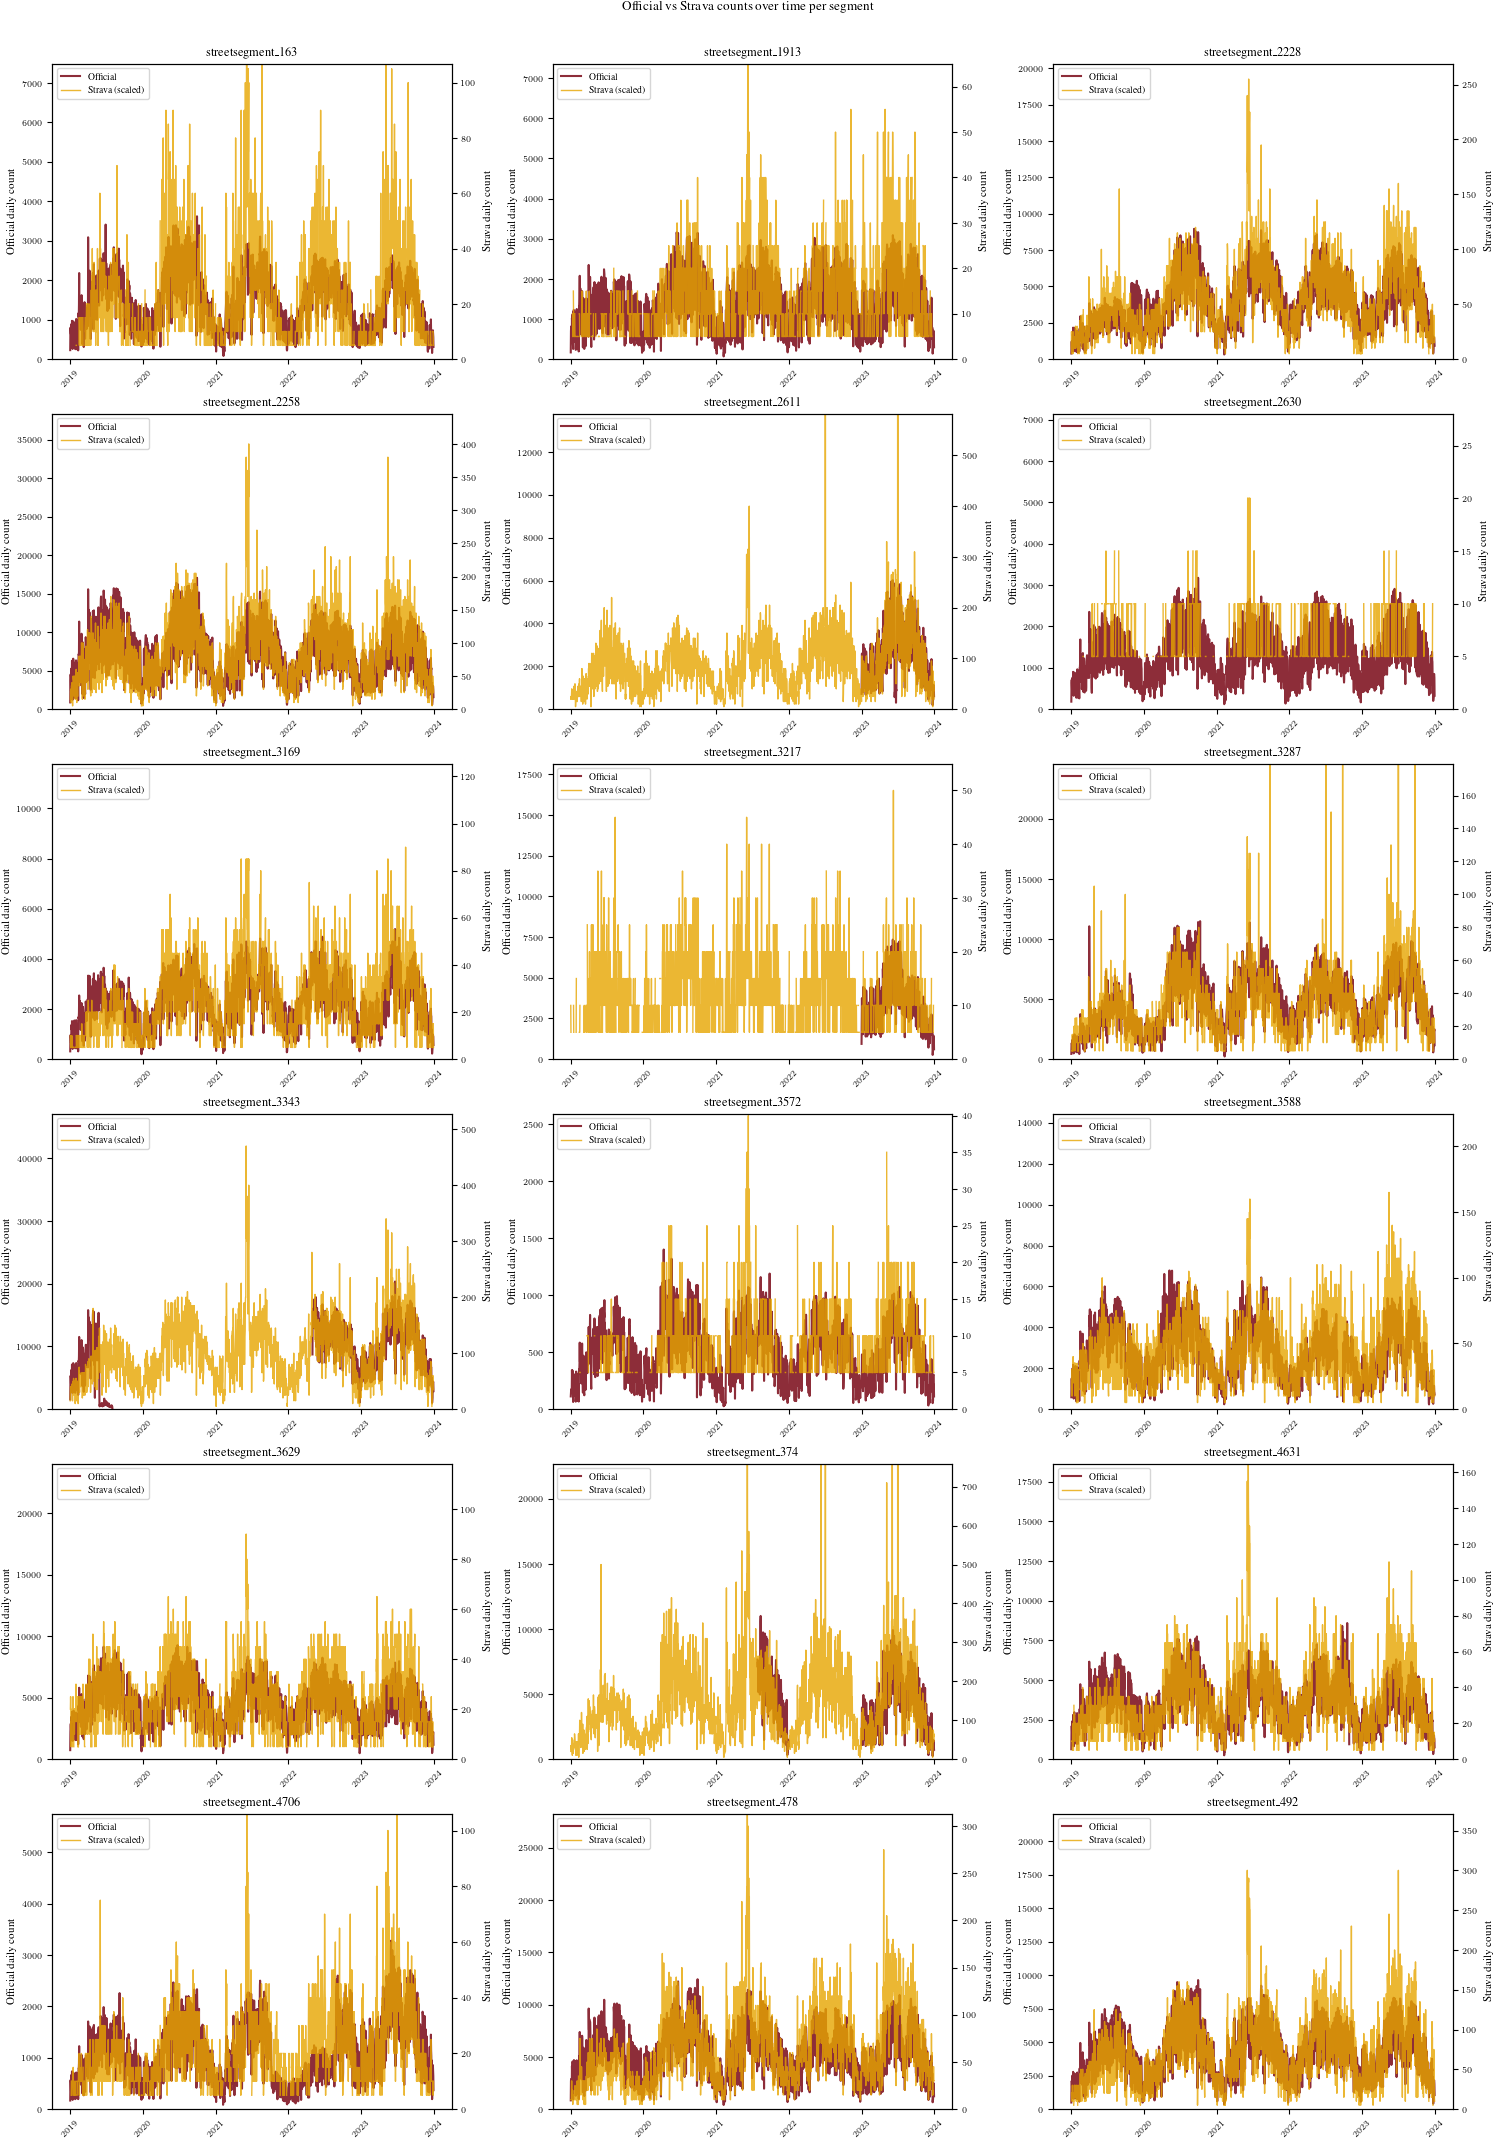

In [32]:
plt.rcParams.update(bundles.icml2024(column="full", nrows=6, ncols=3))
colors = palettes.tue_plot

df = long_daily.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df[["total_count", "strata_count"]] = df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
).replace(0, np.nan)

segments = sorted(df["segment"].dropna().unique())
n_seg, n_cols = len(segments), 3
n_rows = int(np.ceil(n_seg / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 3.5 * n_rows),
    sharex=False, sharey=False
)
axes = np.atleast_1d(axes).flatten()

for ax, seg in zip(axes, segments):
    d = df[df["segment"] == seg].copy().sort_values("date")

    overlap = d.dropna(subset=["total_count", "strata_count"])
    denom = overlap["strata_count"].sum()
    scale_factor = overlap["total_count"].sum() / denom if denom and np.isfinite(denom) else 1.0

    d["strata_scaled"] = d["strata_count"] * scale_factor

    line_official, = ax.plot(
        d["date"], d["total_count"],
        label="Official", color=colors[0], linewidth=1.5
    )
    strava_color = "#E6A500"  # tueplots gold
    line_strava, = ax.plot(
        d["date"], d["strata_scaled"],
        label="Strava (scaled)", color=strava_color, linewidth=1.0, alpha=0.8
    )

    ax.set_title(seg, fontsize=9)
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylabel("Official daily count")

    mean_total = np.nanmean(d["total_count"])
    y_max = 5 * mean_total if np.isfinite(mean_total) and mean_total > 0 else ax.get_ylim()[1]
    ax.set_ylim(0, y_max)

    ax2 = ax.twinx()
    ax2.set_ylim(0, y_max / scale_factor if scale_factor > 0 else y_max)
    ax2.set_ylabel("Strava daily count")

    ax.legend(handles=[line_official, line_strava], loc="upper left", fontsize=7)

for ax in axes[len(segments):]:
    ax.set_visible(False)

fig.suptitle(
    "Official vs Strava counts over time per segment",
    y=1.02
)

if not plt.rcParams.get("figure.constrained_layout.use", False):
    fig.tight_layout()

plt.show()


First, note that the official counts and the Strava counts are scaled differently (up to 15.000 vs. 300 for normal month). Both show similar yearly patterns with falling counts for winter and rising counts for summer. Bike counts for the official data seems stable. As seen before, the Strava data has an upwards trend over the years, probably due to rising user numbers. Unfortunately we only have both Strava and officila counts for 2023 in every segment, so the further validation will only be bason on that year.

### Does the Strava data preserve count relations of the official count data?

For our project we want to calculate the relative risk of each segment to have a bike accident. Therefore, the Strava counts should preserve the relative count between segments. Let's first plot the ratios for the Strava and teh official data for all of 2023.

In [33]:
# export df dataframe 
save_panel(
    df,
    "berlin_counting_stations_strava_comparison.parquet",
    format='parquet'
)

PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_counting_stations_strava_comparison.parquet')

/var/folders/v0/vr_3rk6x4_5816c2kvvz854w0000gn/T/ipykernel_8180/1346087669.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


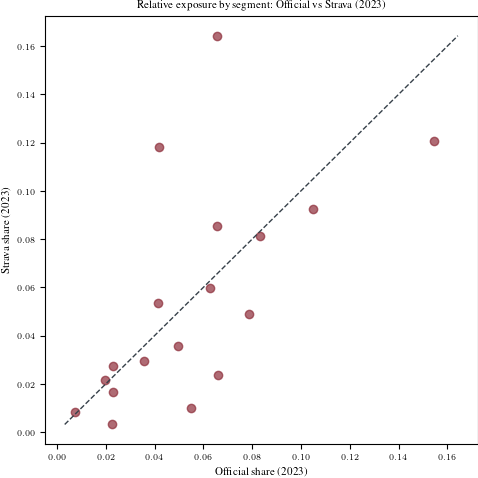

In [34]:
plt.rcParams.update(bundles.icml2024(column="half"))
colors = palettes.tue_plot

# Year 2023: segment share scatter (official vs Strava)
df = long_daily.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df[["total_count", "strata_count"]] = df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
)

df = df[df["date"].dt.year == 2023].dropna(subset=["segment", "total_count", "strata_count"])

yearly = (
    df.groupby("segment", as_index=False)[["total_count", "strata_count"]]
    .sum()
)
yearly["official_share"] = yearly["total_count"] / yearly["total_count"].sum()
yearly["strava_share"] = yearly["strata_count"] / yearly["strata_count"].sum()

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(yearly["official_share"], yearly["strava_share"], alpha=0.7, color=colors[0])

minv = min(yearly["official_share"].min(), yearly["strava_share"].min())
maxv = max(yearly["official_share"].max(), yearly["strava_share"].max())
ax.plot([minv, maxv], [minv, maxv], color=colors[1], linestyle="--", linewidth=1)

ax.set_xlabel("Official share (2023)")
ax.set_ylabel("Strava share (2023)")
ax.set_title("Relative exposure by segment: Official vs Strava (2023)")

plt.tight_layout()
plt.show()

As we can see about two thirds of the official counting stations map quite well to the Strava data. Nevertheless, one third of the counting stations are either over- or underrepresented in the Strava data. Let's look at the correlation of the relative counts, monthly and for all of 2023.

In [35]:
df = long_daily.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df[["total_count", "strata_count"]] = df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
)

df = df[df["date"].dt.year == 2023].dropna(subset=["segment", "total_count", "strata_count"])

# Monthly totals per segment
monthly = (
    df.assign(month=df["date"].dt.to_period("M"))
      .groupby(["segment", "month"], as_index=False)[["total_count", "strata_count"]]
      .sum()
)

# Convert to relative shares within each month
monthly["official_share"] = monthly["total_count"] / monthly.groupby("month")["total_count"].transform("sum")
monthly["strava_share"] = monthly["strata_count"] / monthly.groupby("month")["strata_count"].transform("sum")

# Compare shares per month
def month_stats(d):
    return pd.Series({
        "pearson": d["official_share"].corr(d["strava_share"], method="pearson"),
        "spearman": d["official_share"].corr(d["strava_share"], method="spearman"),
    })

monthly_stats = monthly.groupby("month").apply(month_stats).reset_index()

# Year 2023 totals per segment + shares
yearly = (
    monthly.groupby("segment", as_index=False)[["total_count", "strata_count"]]
    .sum()
)
yearly["official_share"] = yearly["total_count"] / yearly["total_count"].sum()
yearly["strava_share"] = yearly["strata_count"] / yearly["strata_count"].sum()

yearly_pearson = yearly["official_share"].corr(yearly["strava_share"], method="pearson")
yearly_spearman = yearly["official_share"].corr(yearly["strava_share"], method="spearman")

print("Monthly share correlation (2023):")
display(monthly_stats)

print("Yearly share correlation (2023):")
print("  Pearson:", yearly_pearson)
print("  Spearman:", yearly_spearman)

Monthly share correlation (2023):


/var/folders/v0/vr_3rk6x4_5816c2kvvz854w0000gn/T/ipykernel_8180/3389414551.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_stats = monthly.groupby("month").apply(month_stats).reset_index()


month   pearson  spearman
0   2023-01  0.632348  0.614035
1   2023-02  0.656150  0.613320
2   2023-03  0.665445  0.609190
3   2023-04  0.611072  0.704850
4   2023-05  0.652625  0.731682
5   2023-06  0.567489  0.665635
6   2023-07  0.513040  0.731682
7   2023-08  0.662119  0.715170
8   2023-09  0.642086  0.770898
9   2023-10  0.655768  0.708978
10  2023-11  0.659191  0.680083
11  2023-12  0.646988  0.688338

Yearly share correlation (2023):
  Pearson: 0.6192388666403215
  Spearman: 0.6986584107327141


Monthly Pearson correlation ranges between .5 and .65, while the Spearman correlation is a bit higher between .6 and .77. That means that rank is better preserved than the relations. Still, good enough to use the Strava data as a proxy.

Lastly, we should look at the segments that are either under- or overrepresented to get a better idea of the nature of the bias within the Strava data. First we calculate which segments are the furthest off from the diagonal in the earlier plot.

A good rule of thumb to flag a segment as high‑error is if its absolute share error exceeds twice the average share, i.e., $|\Delta s_i| = |s_i^{\text{Strava}} - s_i^{\text{official}}| > 2\cdot(1/N)$, where $N$ is the number of segments.

In [36]:
N = yearly["segment"].nunique()
avg_share = 1 / N
high_error = 2 * avg_share    
high_error


0.1111111111111111

So for our data high error would be about 0.11.

In [37]:
df = long_daily.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df[["total_count", "strata_count"]] = df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
)

df = df[df["date"].dt.year == 2023].dropna(subset=["segment", "total_count", "strata_count"])

yearly = (
    df.groupby("segment", as_index=False)[["total_count", "strata_count"]]
    .sum()
)
yearly["official_share"] = yearly["total_count"] / yearly["total_count"].sum()
yearly["strava_share"] = yearly["strata_count"] / yearly["strata_count"].sum()

# simple relation-preserving error: distance to diagonal
yearly["share_abs_error"] = (yearly["strava_share"] - yearly["official_share"]).abs()

ranked = yearly.sort_values("share_abs_error")  # best at top
ranked.head(20)

segment  total_count  strata_count  official_share  \
10  streetsegment_3572     178691.0        3050.0        0.007395   
16   streetsegment_478    2008251.0       29340.0        0.083112   
0    streetsegment_163     475718.0        7750.0        0.019688   
2   streetsegment_2228    1513709.0       21480.0        0.062645   
15  streetsegment_4706     558415.0        9895.0        0.023110   
6   streetsegment_3169     858680.0       10680.0        0.035537   
1   streetsegment_1913     556384.0        5930.0        0.023026   
11  streetsegment_3588    1004183.0       19295.0        0.041558   
3   streetsegment_2258    2536033.0       33255.0        0.104954   
14  streetsegment_4631    1198351.0       12800.0        0.049594   
5   streetsegment_2630     542625.0        1135.0        0.022457   
17   streetsegment_492    1587426.0       30750.0        0.065696   
8   streetsegment_3287    1904583.0       17610.0        0.078821   
9   streetsegment_3343    3733674.0       43410.0        0.154519   
12  streetsegment_3629    1591422.0        8590.0        0.065861   
7   streetsegment_3217    1325624.0        3560.0        0.054861   
4   streetsegment_2611    1006486.0       42505.0        0.041654   
13   streetsegment_374    1583026.0       59185.0        0.065514   

    strava_share  share_abs_error  
10      0.008467         0.001072  
16      0.081450         0.001661  
0       0.021515         0.001827  
2       0.059630         0.003015  
15      0.027469         0.004359  
6       0.029649         0.005888  
1       0.016462         0.006564  
11      0.053564         0.012006  
3       0.092319         0.012635  
14      0.035534         0.014060  
5       0.003151         0.019306  
17      0.085364         0.019669  
8       0.048887         0.029935  
9       0.120510         0.034009  
12      0.023847         0.042015  
7       0.009883         0.044978  
4       0.117997         0.076344  
13      0.164302         0.098789

Luckily no segment has high error, but the worst offenders seem to be segments 374, 2611, 3217 and 3629. Let's look at them on a map.

In [ ]:
# Compute share_abs_error for 2023
df = long_daily.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df[["total_count", "strata_count"]] = df[["total_count", "strata_count"]].apply(
    pd.to_numeric, errors="coerce"
)

df = df[df["date"].dt.year == 2023].dropna(subset=["segment", "total_count", "strata_count"])

yearly = (
    df.groupby("segment", as_index=False)[["total_count", "strata_count"]]
    .sum()
)
yearly["official_share"] = yearly["total_count"] / yearly["total_count"].sum()
yearly["strava_share"] = yearly["strata_count"] / yearly["strata_count"].sum()
yearly["share_abs_error"] = (yearly["strava_share"] - yearly["official_share"]).abs()

# Join to geometry (folium needs EPSG:4326)
gdf = (
    segment_geo_gdf.merge(
        yearly[["segment", "share_abs_error"]],
        left_on="counter_name",
        right_on="segment",
        how="inner",
    )
    .to_crs(4326)
)

# Build interactive map
m = folium.Map(location=[52.52, 13.405], zoom_start=12, tiles="CartoDB positron")

vals = gdf["share_abs_error"].to_numpy()
vmin = float(np.nanmin(vals))
vmax = float(np.nanmax(vals))
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
cmap.caption = "Absolute share error (2023)"

folium.GeoJson(
    data=json.loads(gdf.to_json()),
    name="Share abs error",
    style_function=lambda f: {
        "color": cmap(f["properties"]["share_abs_error"]),
        "weight": 3,
        "opacity": 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=["counter_name", "share_abs_error"]),
).add_to(m)

cmap.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)
m

So the the segments on Straße des 17. Juni and Karl Marx Allee are overrepresented, while the segments on Kollwitzstraße and Maybachufer are underrepresented. One interpretation might be the former are overrepresented because they are big arterials: wide, direct, and popular for fast rides. Exactly the trips Strava users are most likely to track.
Kollwitzstraße and Maybachufer are underrepresented because they serve slower and local cycling, which is less likely to be recorded by Strava users. These biases should be taken into consideration when later interpreting the relative risk estimates.